<a href="https://colab.research.google.com/github/head1ton/llm_a_z_finetuning/blob/main/notebook/ai_model_etf_huggingface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

허깅페이스에 접속해서 다양한 모델들을 검색해보세요.

https://huggingface.co/

## 데이터 로드

데이터 출처 링크 : https://github.com/bab2min/corpus/tree/master/sentiment

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from sklearn.model_selection import train_test_split

전체 데이터에 해당하는 naver_shopping.txt를 다운로드합니다.



In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/naver_shopping.txt", filename="naver_shopping.txt")

('naver_shopping.txt', <http.client.HTTPMessage at 0x7bf72b9afd70>)

해당 데이터에는 열제목이 별도로 없습니다. 그래서 임의로 두 개의 열제목인 'ratings'와 'reviews'를 추가해주겠습니다.





In [3]:
total_data = pd.read_table('naver_shopping.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


총 20만개의 샘플이 존재합니다. 상위 5개의 샘플만 출력해봅시다.



In [4]:
total_data[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [5]:
total_data['ratings'].value_counts()

,count
ratings,
5,81177
2,63989
1,36048
4,18786


## 훈련 데이터와 테스트 데이터 분리하기


현재 갖고 있는 데이터는 레이블을 별도로 갖고있지 않습니다. 평점이 4, 5인 리뷰에는 레이블 1을, 평점이 1, 2인 리뷰에는 레이블 0을 부여합니다. 부여된 레이블은 새로 생성한 label이라는 열에 저장합니다.

In [6]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


각 열에 대해서 중복을 제외한 샘플의 수를 카운트합니다.



In [7]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [11]:
total_data[ 'ratings'].value_counts()

,count
ratings,
5,81177
2,63989
1,36048
4,18786


ratings열의 경우 1, 2, 4, 5라는 네 가지 값을 가지고 있습니다. reviews열에서 중복을 제외한 경우 199,908개입니다. 현재 20만개의 리뷰가 존재하므로 이는 현재 갖고 있는 데이터에 중복인 샘플들이 있다는 의미입니다. 중복인 샘플들을 제거해줍니다.

`데이터프레임의이름.drop_duplicates(subset=['중복을제거할기준이되는열'], inplace=True)`

In [12]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 199908


`데이터프레임의이름.isnull().values.any()`: 결측값, 쓰레기값이 존재하지는 유무

In [13]:
print(total_data.isnull().values.any())

False


훈련 데이터와 테스트 데이터를 3:1 비율로 분리합니다.



In [14]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


훈련용 리뷰의 경우 약 14만 9,900개. 테스트용 리뷰의 경우 약 4만 9,900개가 존재합니다. 훈련용 리뷰 상위 5개를 출력해봅시다. 분할 과정에서 데이터가 섞였으므로 이전 출력 결과와는 다릅니다.

In [15]:
train_data.head()

,ratings,reviews,label
59666,2,사이즈를 3센치씩 늘린건데도 작아요 그리고 색상은 완전 달라요 칙칙한핑크네요ㅠㅠ 많...,0
12433,2,ㅂ불만족.. 빗이 아픔 .. 멍이피부에 빗질못해주겟네요,0
146516,1,이 제품쓰고 삼일만에 변기물이 잘 안내려갔어요. 혹시나해서 다시 빼보니 물이 다시 ...,0
158109,5,적당하고 만족합니다,1
70219,2,편하자고 이용하는 밀키튼데 손 은근 많이 가서 저는 패쓰요,0


## 레이블의 분포 확인

훈련 데이터의 레이블의 분포를 확인해봅시다.



<Axes: xlabel='label'>

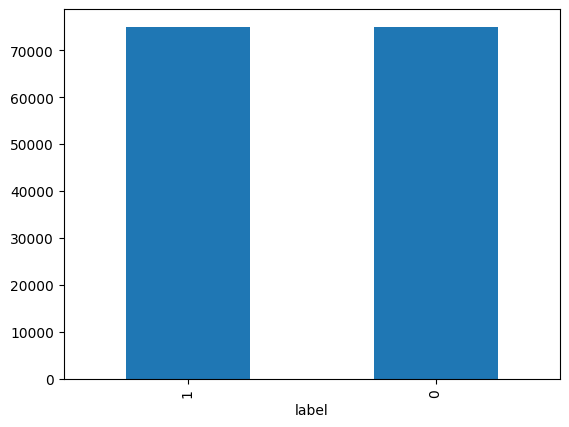

In [16]:
train_data['label'].value_counts().plot(kind = 'bar')

In [19]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  74918
1      1  75013


두 레이블 모두 약 7만 5천개로 50:50 비율을 가지고 있습니다.



## 실전 모델링 (감성 분류)

In [20]:
!pip install -q transformers

`https://huggingface.co/`에 접속하여 검색창을 통해서 원하는 모델을 검색할 수 있습니다. 기본적으로 영어로 검색해야 하는데, 한국어 모델을 찾는 경우에는 `ko`라는 키워드를 사용하고, 원하는 태스크에 맞는 키워드를 같이 입력합니다. 예를 들어 한국어 감성 분류 모델을 찾는 경우에는 `ko sentiment`라고 검색합니다.  

![](https://wikidocs.net/images/page/218774/%EC%82%AC%EC%A7%841.PNG)  

몇 가지 모델 후보가 나오는데 모델들의 사용법이 자세히 나와있는지, 또는 모델들을 비교하였을 때 내 데이터에 성능이 적절히 잘 나오는지 등으로 모델을 사용할지 판단할 수 있습니다. 여기서는 가장 상단에 위치한 모델인 `
matthewburke/korean_sentiment`를 클릭해봅시다.  

![](https://wikidocs.net/images/page/218774/%EB%AA%A8%EB%8D%B82.PNG)  

이후에는 해당 모델의 예시 코드가 나옵니다.

![](https://wikidocs.net/images/page/218774/%EB%AA%A8%EB%8D%B8%EC%82%AC%EC%9A%A9%EB%B2%95.PNG)  

해당 모델의 예시 코드를 그대로 실행해봅시다.

In [22]:
preds

[[{'label': 'LABEL_0', 'score': 0.02684817463159561},
  {'label': 'LABEL_1', 'score': 0.9731518626213074}]]

In [23]:
preds[0]

[{'label': 'LABEL_0', 'score': 0.02684817463159561},
 {'label': 'LABEL_1', 'score': 0.9731518626213074}]

In [24]:
preds[0][1]

{'label': 'LABEL_1', 'score': 0.9731518626213074}

In [21]:
from transformers import pipeline

classifier = pipeline("text-classification", model="matthewburke/korean_sentiment")
custom_tweet = "영화 재밌다."
preds = classifier(custom_tweet, return_all_scores=True)
is_positive = preds[0][1]['score'] > 0.5

print('스코어 점수 확인 :', preds[0][1]['score'])
print('긍정 여부 :', is_positive)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/887 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


스코어 점수 확인 : 0.9731518626213074
긍정 여부 : True


위 모델은 임의의 예측값 "영화 재밌다."에 대해서 일종의 스코어. 즉, 감성 점수를 얻은 뒤에 0.5보다 클 경우에는 긍정으로 판단하고 있습니다. 다시 말해 "영화 재밌다" 대신에 다른 입력을 넣었을 때도 같은 기준으로 0.5보다 크다면 긍정, 0.5보다 작으면 부정으로 판단하면 된다는 의미입니다.  

In [25]:
test_data.head()

,ratings,reviews,label
193242,1,너무 낮고 솜도 적고 실망스럽습니다,0
125080,1,피부에 뾰루지가 많이 올라와요,0
122750,5,배송도 빠르네요 가격대비 좋은것 같아요~~~ 첨에는 힘들어하나 조금 지나니 잘 하네요,1
72927,5,재구매입니다. 핏도 좋고 착용감도 좋습니다.,1
83890,1,파손제품 온거 출장같다 오늘 받았는데 현재상황 장난하시는지 택배회사 항의하세요,0


In [26]:
def pred_sentiment(text):
  preds = classifier(text, return_all_scores=True)
  if preds[0][1]['score'] > 0.5:
    return 1
  else:
    return 0

In [27]:
pred_sentiment('피부에 뾰루지가 많이 올라와요')

/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


0

In [28]:
pred_sentiment('직장을 가지고 싶은데 직장이 잘 안 구해져')

/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


0

In [29]:
from tqdm import tqdm
tqdm.pandas()

In [30]:
# 테스트 데이터 중 상위 1,000개만 복사
test_data_for_sample = test_data[:1000].copy()

In [31]:
test_data_for_sample

,ratings,reviews,label
193242,1,너무 낮고 솜도 적고 실망스럽습니다,0
125080,1,피부에 뾰루지가 많이 올라와요,0
122750,5,배송도 빠르네요 가격대비 좋은것 같아요~~~ 첨에는 힘들어하나 조금 지나니 잘 하네요,1
72927,5,재구매입니다. 핏도 좋고 착용감도 좋습니다.,1
83890,1,파손제품 온거 출장같다 오늘 받았는데 현재상황 장난하시는지 택배회사 항의하세요,0
...,...,...,...
148745,4,좋아요 딱 맞아요 배송 일주일,1
138045,5,빨간색 검은색 샀어요 있는 것만으로도 든든하네요 잘 쓸께요,1
160462,5,설치 꼼꼼하게 잘해주셨고~ 저렴한 가격에 잘 설치했어요,1
24513,5,마블 구매했다가 품절이라 그레이로 변경했는데 그레이도 넘 이쁘네여~! 가격도 저렴하...,1


In [32]:
test_data_for_sample['pred'] = test_data_for_sample['reviews'].progress_apply(pred_sentiment)

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
100%|██████████| 1000/1000 [00:10<00:00, 92.66it/s]


In [33]:
test_data_for_sample

,ratings,reviews,label,pred
193242,1,너무 낮고 솜도 적고 실망스럽습니다,0,0
125080,1,피부에 뾰루지가 많이 올라와요,0,0
122750,5,배송도 빠르네요 가격대비 좋은것 같아요~~~ 첨에는 힘들어하나 조금 지나니 잘 하네요,1,1
72927,5,재구매입니다. 핏도 좋고 착용감도 좋습니다.,1,1
83890,1,파손제품 온거 출장같다 오늘 받았는데 현재상황 장난하시는지 택배회사 항의하세요,0,0
...,...,...,...,...
148745,4,좋아요 딱 맞아요 배송 일주일,1,1
138045,5,빨간색 검은색 샀어요 있는 것만으로도 든든하네요 잘 쓸께요,1,1
160462,5,설치 꼼꼼하게 잘해주셨고~ 저렴한 가격에 잘 설치했어요,1,1
24513,5,마블 구매했다가 품절이라 그레이로 변경했는데 그레이도 넘 이쁘네여~! 가격도 저렴하...,1,1


In [34]:
# 정확도 계산 함수
def compute_accuracy(df):
    correct = (df['pred'] == df['label']).sum()
    total = len(df)
    return correct / total

In [35]:
acc = compute_accuracy(test_data_for_sample)
print('정확도(%):', acc * 100)

정확도(%): 87.6


아무런 학습없이 적절히 모델을 선택만 하여도 1,000개의 테스트 데이터에서 정확도가 87.6%가 넘는 모델을 얻었습니다.

## 실전 모델링 (텍스트 요약기)

이번에는 난이도가 높은 작업인 텍스트 요약 모델로 빠르게 데모를 만들어봅시다. 이번에는 검색창에 한국어 요약 모델을 찾기 위해서 `ko summarization` 이라고 입력하고 가장 상단의 모델을 클릭합니다.  

![](https://wikidocs.net/images/page/218774/%EB%AA%A8%EB%8D%B8_y4tyNKX.PNG)  

예시 코드를 그대로 사용해봅시다.

In [36]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained('eenzeenee/t5-base-korean-summarization')
tokenizer = AutoTokenizer.from_pretrained('eenzeenee/t5-base-korean-summarization')

prefix = "summarize: "
sample = """
    안녕하세요? 우리 (2학년)/(이 학년) 친구들 우리 친구들 학교에 가서 진짜 (2학년)/(이 학년) 이 되고 싶었는데 학교에 못 가고 있어서 답답하죠?
    그래도 우리 친구들의 안전과 건강이 최우선이니까요 오늘부터 선생님이랑 매일 매일 국어 여행을 떠나보도록 해요.
    어/ 시간이 벌써 이렇게 됐나요? 늦었어요. 늦었어요. 빨리 국어 여행을 떠나야 돼요.
    그런데 어/ 국어여행을 떠나기 전에 우리가 준비물을 챙겨야 되겠죠? 국어 여행을 떠날 준비물, 교안을 어떻게 받을 수 있는지 선생님이 설명을 해줄게요.
    (EBS)/(이비에스) 초등을 검색해서 들어가면요 첫화면이 이렇게 나와요.
    자/ 그러면요 여기 (X)/(엑스) 눌러주(고요)/(구요). 저기 (동그라미)/(똥그라미) (EBS)/(이비에스) (2주)/(이 주) 라이브특강이라고 되어있죠?
    거기를 바로 가기를 누릅니다. 자/ (누르면요)/(눌르면요). 어떻게 되냐? b/ 밑으로 내려요 내려요 내려요 쭉 내려요.
    우리 몇 학년이죠? 아/ (2학년)/(이 학년) 이죠 (2학년)/(이 학년)의 무슨 과목? 국어.
    이번주는 (1주)/(일 주) 차니까요 여기 교안. 다음주는 여기서 다운을 받으면 돼요.
    이 교안을 클릭을 하면, 짜잔/. 이렇게 교재가 나옵니다 .이 교안을 (다운)/(따운)받아서 우리 국어여행을 떠날 수가 있어요.
    그럼 우리 진짜로 국어 여행을 한번 떠나보도록 해요? 국어여행 출발. 자/ (1단원)/(일 단원) 제목이 뭔가요? 한번 찾아봐요.
    시를 즐겨요 에요. 그냥 시를 읽어요 가 아니에요. 시를 즐겨야 돼요 즐겨야 돼. 어떻게 즐길까? 일단은 내내 시를 즐기는 방법에 대해서 공부를 할 건데요.
    그럼 오늘은요 어떻게 즐길까요? 오늘 공부할 내용은요 시를 여러 가지 방법으로 읽기를 공부할겁니다.
    어떻게 여러가지 방법으로 읽을까 우리 공부해 보도록 해요. 오늘의 시 나와라 짜잔/! 시가 나왔습니다 시의 제목이 뭔가요? 다툰 날이에요 다툰 날.
    누구랑 다퉜나 동생이랑 다퉜나 언니랑 친구랑? 누구랑 다퉜는지 선생님이 시를 읽어 줄 테니까 한번 생각을 해보도록 해요."""

inputs = [prefix + sample]


inputs = tokenizer(inputs, max_length=512, truncation=True, return_tensors="pt")
output = model.generate(**inputs, num_beams=3, do_sample=True, min_length=10, max_length=64)
decoded_output = tokenizer.batch_decode(output, skip_special_tokens=True)[0]
result = nltk.sent_tokenize(decoded_output.strip())[0]

print('RESULT >>', result)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


config.json:   0%|          | 0.00/782 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.10G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

RESULT >> 국어 여행을 떠나기 전에 국어 여행을 떠날 준비물과 교안을 어떻게 받을 수 있는지 선생님이 설명해 준다.


위 예시 코드를 참고로 임의의 입력에 대해서 텍스트 요약문을 출력하는 함수 `summarize()`를 구현합니다.

In [37]:
def summarize(sample):
  prefix = "summarize: "
  inputs = [prefix + sample]
  inputs = tokenizer(inputs, max_length=512, truncation=True, return_tensors="pt")
  output = model.generate(**inputs, num_beams=3, do_sample=True, min_length=10, max_length=64)
  decoded_output = tokenizer.batch_decode(output, skip_special_tokens=True)[0]
  result = nltk.sent_tokenize(decoded_output.strip())[0]
  return result

In [38]:
text = '''배우 배수지가 매니지먼트 숲과 전속계약을 체결했다. 수지는 8일 자신의 인스타그램에 '데뷔 때 부터 함께해온 소속사 JYP와 계약기간을 마치고 오늘부터 새로운 소속사 매니지먼트 숲과 함께 하게 되었다'고 밝혔다. 이어 수지는 '연습생으로 시작해서, 데뷔하고 9년의 시간이 흐른 지금까지, JYP와 함께했던 여러 영광의 순간들이 스쳐지나간다'면서 '9년 동안 항상 옆에서 서포트 해주셨던 JYP 모든 직원분들께 진심으로 감사드린다'고 인사를 잊지 않았다. 2010년 걸그룹 '미쓰에이'로 데뷔한 배수지는 2011년 KBS2 드라마 '드림하이'로 첫 연기 활동을 시작했다. 2012년 영화 '건축학개론'을 통해 스크린 데뷔를 한 뒤 가수 활동과 연기 활동을 꾸준히 병행해 오고 있다. 매니지먼트 숲 관계자는 '배우 배수지의 장점과 매력을 극대화할 수 있는 작품 선택부터 국내외 활동, 가수로서의 솔로 활동까지 활발하게 이루어질 수 있도록 지원할 예정이다'고 전했다. 특히 올해는 작품을 통해 연기자 배수지로 대중들과 만날 예정이다. 현재 촬영 중인 SBS 드라마 '배가본드'는 민항 여객기 추락 사고에 연루된 한 남자가 은폐된 진실 속에서 찾아낸 거대한 국가 비리를 파헤치게 되는 과정을 담은 이야기다. 배수지는 국정원 블랙요원 고해리 역으로 출연하며, 뒤이어 영화 '백두산'에도 합류한다. 매니지먼트 숲은 공유, 공효진, 김재욱, 서현진, 이천희, 전도연, 정유미, 남지현, 최우식, 유민규, 이재준, 정가람, 전소니 등 소속되어 있다.'''

In [39]:
result = summarize(text)
print(result)

배우 배수지는 소속사 JYP와 계약기간을 마치고 새로운 소속사 매니지먼트 숲과 전속계약을 체결했다.
